In [ ]:
import os
import time
import gymnasium as gym
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
import argparse

from mdn_rnn_net import RNN
from vae import VAE
from utils.memory import Memory

# Fix Argparse in ipython
import sys
sys.argv=['']

In [ ]:
def parse_args():
    parser = argparse.ArgumentParser()

    # ---------- General settings --------- #
    
    parser.add_argument("--gym-env", type=str, default="ALE/MontezumaRevenge-v5")
    parser.add_argument("--seed", type=int, default=1)
    parser.add_argument("--debug", action='store_true')

    parser.add_argument("--n-episodes", type=int, default=300)
    parser.add_argument("--n-steps", type=int, default=512)
    parser.add_argument("--save_interval", type=int, default=20)

    # ---------- Data Settings  ---------- #
    parser.add_argument("--death-augment", action="store_true")
    parser.add_argument("--death-reps", type=int, default=8)

    # ---------- Vae settings ---------- #

    # Training
    parser.add_argument("--train-vae-off", action="store_false")
    parser.add_argument("--vae-n-epochs", type=int, default=20)
    parser.add_argument("--vae-learning-rate", type=float, default=1e-3)
    parser.add_argument("--vae-batch-size", type=int, default=32)

    # Network setup
    parser.add_argument("--img-size", type=int, default=96)

    # ---------- RNN settings ----------- #

    # Training
    parser.add_argument("--rnn-deterministic", action="store_true")
    parser.add_argument("--train-rnn-off", action="store_false")
    parser.add_argument("--rnn-n-epochs", type=int, default=20)
    parser.add_argument("--rnn-clip-value", type=float, default=0.5)
    parser.add_argument("--rnn-learning-rate", type=float, default=1e-3)

    # Network setup
    parser.add_argument("--load-rnn", action='store_true')
    parser.add_argument("--rnn-input-size", type=int, default=33)
    parser.add_argument("--rnn-sequence_length", type=int, default=32)
    parser.add_argument("--rnn-batch-size", type=int, default=32)
    parser.add_argument("--rnn-h-size", type=int, default=512)
    parser.add_argument("--rnn-n-layers", type=int, default=1)
    parser.add_argument("--rnn-output-size", type=int, default=33) # z-state + reward
    parser.add_argument("--rnn-n-mixtures", type=int, default=5)

    args = parser.parse_args()
    return args

In [ ]:
args = parse_args()

 # CUDA setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

# Env setup
env = gym.make(args.gym_env, render_mode = "rgb_array", frameskip = 8)
env = gym.wrappers.ResizeObservation(env, args.img_size)
env = gym.wrappers.TransformReward(env, lambda r: r*10e-5)
seed = 3
action_space = [0,1,2,3,4,5,11,12]

# Memory setup
memory = Memory(env, args)

# VAE setup
vae = VAE(args)
vae_load_path = f"models/MR_vae_{args.img_size}.pth"
vae.load(vae_load_path)

# RNN Setup
rnn = RNN(args)
rnn_load_path = "checkpoints/main_bce_MontezumaRevenge-v5_vae-96_mdn-rnn-1-512_1056_23-04-2023/300.pth"

rnn.load(rnn_load_path)



In [ ]:
# Test: Run 10 episodes of args.n_stps random actions (on function with two loss functions: BCE_loss + MDN_loss)

n_episodes = 10
threshold = 0.5

episode_true_positive_deaths = []
episode_false_positive_deaths = []
episode_total_deaths = 0
episode_losses = []
for episode in range(n_episodes):
    memory.clear()
    random.seed(seed + episode)
    state, info = env.reset(seed = seed + episode)
    lives = info['lives']
    reward = 0
    death = 0
    terminated = False

    for step in range(0, args.n_steps):

        # Reset if terminated
        if terminated:
            memory.append_state(state)
            memory.append_action(0)
            memory.append_reward(reward)
            memory.append_death(death)

            state, info = env.reset(seed = seed + episode + step)
            lives = info['lives']
            reward = 0
            death = 0
            terminated = False
        
        else:
            # Append to memory
            memory.append_state(state)
            action = random.choice(action_space)
            memory.append_action(action)
            memory.append_reward(reward)
            memory.append_death(death)

            # Step in environment
            state, reward, terminated, truncated, info = env.step(action)
            
            # Determine death
            if lives > info['lives']:
                death = 1
                for _ in range (5): env.step(0) # It takes 5 frames to respawn
            else:
                death = 0
            lives = info['lives']
            
    # VAE forward pass
    states = memory.get_states()
    z_states = vae.encode(states)

    # RNN forward pass
    za_sequences, targets = memory.make_rnn_training_data(z_states)

     # Forward pass & Compute loss
    if args.rnn_deterministic:
        z_preds, deaths = rnn.rnn(za_sequences)
        rnn_loss = F.mse_loss(z_preds, targets[ : , : -1])
    else:
        pi, mu, sigma, deaths = rnn.rnn(za_sequences)
        rnn_loss = rnn.mdn_loss(pi, mu, sigma, targets[ : , : -1])
    
    bce_loss = F.binary_cross_entropy(deaths, targets[ : ,-1])
    
    loss = rnn_loss + bce_loss

    episode_losses.append(loss.item())

    # Compute correct death predictions
    death_indices = [i for i in range(targets.shape[0]) if targets[i][-1] == 1]
    total_deaths = len(death_indices)
    episode_total_deaths += total_deaths
    
    true_death_preds = 0
    false_death_preds = 0
    for i in range(targets.shape[0]):
        if i in death_indices and deaths[i] >= threshold:
            true_death_preds += 1
        if i not in death_indices and deaths[i] >= threshold:
            false_death_preds += 1
    
    episode_true_positive_deaths.append(true_death_preds)
    episode_false_positive_deaths.append(false_death_preds)

# Metric calculations
TP = sum(episode_true_positive_deaths)
FP = sum(episode_false_positive_deaths)
PPV = TP / (TP + FP)
TPR = TP / episode_total_deaths
FPR = FP / (targets.shape[0] - episode_total_deaths)
TNR = 1 - FPR
F1 = (2*TPR*PPV) / (TPR + PPV)

# Prints
print(f"Avg. losses | RNN: {np.mean(episode_losses[0])}")
print(f"Threshold: {threshold}")
print(f"TP:  {TP} / {episode_total_deaths}")
print(f"FP:  {FP} / {targets.shape[0] - episode_total_deaths}")
print(f"PPV: {PPV*100:.2f}")
print(f"TPR: {TPR*100:.2f}")
print(f"FPR: {FPR*100:.2f}")
print(f"TNR: {TNR*100:.2f}")
print(f"F1 : {F1*100:.2f}")


In [70]:
# Generate rollout
seed = 3
memory.clear()
random.seed(seed)
state, info = env.reset(seed = seed)
lives = info['lives']
reward = 0
death = 0
terminated = False

for step in range(0, args.n_steps):

    # Reset if terminated
    if terminated:
        memory.append_state(state)
        memory.append_action(0)
        memory.append_reward(reward)
        memory.append_death(death)

        state, info = env.reset(seed = seed + step)
        lives = info['lives']
        reward = 0
        death = 0
        terminated = False
    
    else:
        # Append to memory
        memory.append_state(state)
        action = random.choice(action_space)
        memory.append_action(action)
        memory.append_reward(reward)
        memory.append_death(death)

        # Step in environment
        state, reward, terminated, truncated, info = env.step(action)
        
        # Determine death
        if lives > info['lives']:
            death = 1
            for _ in range (5): env.step(0) # It takes 5 frames to respawn
        else:
            death = 0
        lives = info['lives']
        
# VAE forward pass
states = memory.get_states()
z_states = vae.encode(states)


# Generate training data for MDN-RNN
za_sequences, targets = memory.make_rnn_training_data(z_states)


In [138]:
def show_prediction(i):
    za_sequence = za_sequences[i].unsqueeze(0)

    # Forward pass
    pi, mu, sigma, death = rnn.rnn(za_sequence)
    #pred = rnn.sample(pi, mu, sigma)
    pred = rnn.mean(pi,mu)

    # Format prediction
    z_state = pred[ : , : -1]
    reward = pred[-1][-1]
    
    # Reconstruct predicted image
    r_img = vae.decode(z_state)
    r_img = r_img.squeeze()

    # Generate target image
    target = targets[i][:-2].unsqueeze(0)
    t_img = vae.decode(target)
    t_img = t_img.squeeze()

    # Plot
    fig = plt.figure(figsize=(20,10))
    rows = 1
    columns = 3

    fig.add_subplot(rows, columns, 1)
    org_img = np.transpose(states[i+args.rnn_sequence_length+1].cpu().numpy(), [1,2,0])
    plt.imshow(org_img)
    #plt.title("Original")
    plt.axis('off')

    fig.add_subplot(rows, columns, 2)
    t_img = np.transpose(t_img.detach().numpy(), [1,2,0])
    plt.imshow(t_img)
    #plt.title("CNN-VAE Reconstruction")
    plt.axis('off')

    fig.add_subplot(rows, columns, 3)
    r_img= np.transpose(r_img.detach().numpy(), [1,2,0])
    plt.imshow(np.squeeze(r_img))
    #plt.title("MDN-RNN Prediction")
    plt.axis('off')
    return reward.item(), death.item()

Predicted reward:  0.005457947961986065
Target reward:  0.0
Predicted death:  0.003441654145717621
Target death:  0.0
Death occurences:  [84, 221, 280, 305, 330, 368, 394, 453, 476]


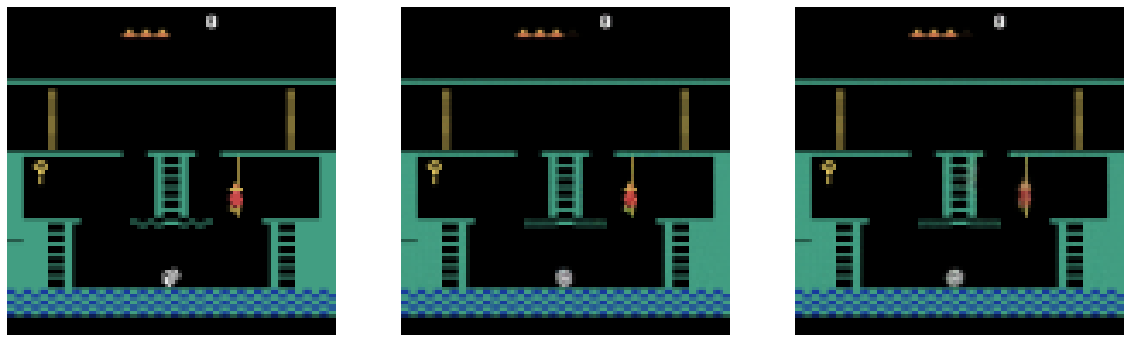

In [253]:
i = 0
reward, death = show_prediction(i)
print("Predicted reward: ", reward)
print("Target reward: ", targets[i][-2].item())
print("Predicted death: ", death)
print("Target death: ", targets[i][-1].item())

# Get death occurences
death_occur = [i for i in range(targets.shape[0]) if targets[i][-1] == 1]
print("Death occurences: ", death_occur)